In [1]:
%pwd
from theano.sandbox import cuda
cuda.use('gpu0')

Using gpu device 0: GeForce GTX 760 (CNMeM is disabled, cuDNN 5105)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
import os
base= os.getcwd() + "/data/redux"
# base= os.getcwd() + "/data/redux/sample"
train= base+"/train"
test= base+"/test"
valid= base+"/valid"
results_path = base+"/results"


In [3]:
from matplotlib import pyplot as plt
import bcolz
def plot(img):
    plt.imshow(img)
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

In [4]:

    
import json   
import keras.preprocessing.image as preprocess
from keras.models import Sequential
import numpy as np
from keras.layers.core import Lambda, Flatten, Dropout, Dense
from keras.layers.convolutional import ZeroPadding2D, Convolution2D, MaxPooling2D
from keras.utils.data_utils import get_file
from keras.optimizers import Adam


vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    """
        Subtracts the mean RGB value, and transposes RGB to BGR.
        The mean RGB was computed on the image set used to train the VGG model.

        Args: 
            x: Image array (height x width x channels)
        Returns:
            Image array (height x width x transposed_channels)
    """
    x = x - vgg_mean
#     print x
#     import pdb;pdb.set_trace()
    return x[:, ::-1] # reverse axis rgb->bgr

class hgg:
    def get_classes(self):
        fname = 'imagenet_class_index.json'
        fpath = get_file(fname, self.FILE_PATH+fname, cache_subdir='models')
        with open(fpath) as f:
            class_dict = json.load(f)
        self.classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

    def get_batches(self,path, shuffle=True, batch_size=8, rotation_range=10 ,width_shift_range=10, height_shift_range=10, shear_range=0.3 ):
#         imageGenerator doc at https://keras.io/preprocessing/image/
        imageGenerator = preprocess.ImageDataGenerator(
#             rotation_range=rotation_range,
#             width_shift_range=width_shift_range,
#             height_shift_range=height_shift_range,
#             shear_range=shear_range,
#             zoom_range=0
        )
        return imageGenerator.flow_from_directory(
            shuffle=shuffle,
            directory=path, 
            target_size=(224,224),
            batch_size=batch_size,
            class_mode='categorical'
        )
    def __init__(self):
        self.FILE_PATH = 'http://files.fast.ai/models/'

        self.createModel()
        self.get_classes()
        pass
    def createModel(self,):
        # Sequential doc at https://keras.io/getting-started/sequential-model-guide/
        self.model=Sequential()
        self.model.add(Lambda(vgg_preprocess, input_shape=(3,224,224), output_shape=(3,224,224)))
        self.addConvLayer(2,64)
        self.addConvLayer(2,128)
        self.addConvLayer(3,256)
        self.addConvLayer(3,512)
        self.addConvLayer(3,512)
        
        self.model.add(Flatten())
        
        self.model.add(Dense(4096,activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(4096,activation='relu'))
        self.model.add(Dropout(0.5))
        
        
        self.model.add(Dense(1000,activation='softmax'))
        
        
        fname="vgg16.h5"
        self.model.load_weights(get_file(fname, self.FILE_PATH+fname, cache_subdir='models'))
        
    def addConvLayer(self,layers,filters):
        # Convolution2D https://keras.io/layers/convolutional/
        for i in range(layers):
            self.model.add(ZeroPadding2D((1,1)))
            self.model.add(Convolution2D(filters,3,3,activation='relu'))
        self.model.add(MaxPooling2D((2,2),strides=(2,2)))
        
    def ModifyLastLayerToNewOutput(self, no_of_outputs):
        self.model.pop()
        for layer in self.model.layers: layer.trainable=False
        self.model.add(Dense(no_of_outputs,activation='softmax'))
        print no_of_outputs
        self.compile()
    def finetune(self,batches):
        self.ModifyLastLayerToNewOutput(batches.nb_class)
        classes = list(iter(batches.class_indices)) # get a list of all the class labels
        
        # batches.class_indices is a dict with the class name as key and an index as value
        # eg. {'cats': 0, 'dogs': 1}

        # sort the class labels by index according to batches.class_indices and update model.classes
        for c in batches.class_indices:
            classes[batches.class_indices[c]] = c
        self.classes = classes
        
        
    def compile(self, lr=0.01):
        self.model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy',metrics=['accuracy'])
    def fit(self,train_batches, validation_batches):
        self.model.fit_generator(train_batches, 
                        samples_per_epoch = train_batches.nb_sample,
                        nb_epoch=1, 
                        validation_data = validation_batches,
                        nb_val_samples = validation_batches.nb_sample,
                       )
   
h = hgg()
# from vgg16 import Vgg16

# h=Vgg16()

Using Theano backend.


In [5]:
train_batches = h.get_batches(train)
validation_batches = h.get_batches(valid)
test_batches = h.get_batches(test)
# validation_batches
# plot(validation_batches)


Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [6]:
h.finetune(train_batches)



2


In [7]:
train_now=False
no_of_epochs=3
if train_now==True:
    latest_weights_filename = None
    for epoch in range(no_of_epochs):
        print "Running epoch: %d" % epoch
        if(epoch>=2):
            h.model.optimizer.lr = 0.001
        h.fit(train_batches, validation_batches)
        latest_weights_filename = '/ft%d.h5' % epoch
        h.model.save_weights(results_path+latest_weights_filename)
    print "Completed %s fit operations" % no_of_epochs
else:
    print "loading from saved_model"
    h.model.load_weights(results_path+"/ft2.h5")
    


loading from saved_model


In [8]:
preds=h.model.predict_generator(validation_batches, validation_batches.nb_sample)

In [47]:
is_dog = np.round(1- preds)
print is_dog[:5]
filenames = validation_batches.filenames
print filenames[:5]
print len(preds)

[[ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]]
['cats/cat.3559.jpg', 'cats/cat.3212.jpg', 'cats/cat.2855.jpg', 'cats/cat.9422.jpg', 'cats/cat.5571.jpg']
2000


In [48]:
with open("submit.txt","a") as f:
    f.write("id,label\n")
    for i in range(len(preds)):
        if(is_dog[i][0]==1):
            is_dog[i][0]=0.05
        else:
            is_dog[i][0]=0.95
        print filenames[i][8:-4],",",is_dog[i][0]
        f.write("%s,%s\n"%(str(filenames[i][8:-4]),str(is_dog[i][0])) )

.3559 , 0.95
.3212 , 0.95
.2855 , 0.05
.9422 , 0.05
.5571 , 0.95
.12199 , 0.05
.6003 , 0.05
.1801 , 0.95
.2367 , 0.05
.7540 , 0.05
.6316 , 0.05
.2863 , 0.95
.1713 , 0.05
.10710 , 0.05
.3736 , 0.95
.7519 , 0.05
.10698 , 0.05
.11952 , 0.95
.1530 , 0.95
.9564 , 0.95
.11632 , 0.05
.6915 , 0.05
.6836 , 0.95
.4077 , 0.05
.6659 , 0.05
.8450 , 0.05
.2834 , 0.95
.7016 , 0.95
.11171 , 0.05
.10172 , 0.05
.8035 , 0.95
.8940 , 0.05
.6487 , 0.95
.9808 , 0.05
.11826 , 0.05
.10924 , 0.95
.11936 , 0.95
.5250 , 0.05
.1281 , 0.95
.7816 , 0.05
.991 , 0.05
.2954 , 0.05
.6589 , 0.05
.2970 , 0.05
.2463 , 0.05
.888 , 0.05
.11335 , 0.05
.10932 , 0.95
.8575 , 0.95
.9910 , 0.95
.375 , 0.05
.5913 , 0.95
.5847 , 0.95
.7343 , 0.95
.2717 , 0.05
.9298 , 0.05
.7175 , 0.95
.18 , 0.05
.827 , 0.05
.8543 , 0.95
.10127 , 0.05
.4428 , 0.95
.5000 , 0.05
.9417 , 0.05
.6883 , 0.05
.5668 , 0.05
.4935 , 0.05
.10952 , 0.95
.4161 , 0.05
.9832 , 0.05
.1407 , 0.95
.8163 , 0.05
.10060 , 0.95
.3772 , 0.05
.7174 , 0.05
.1417 , 0.05
.50

243
[ 1.  0.]
0.05
cats/cat.1200.jpg
2000


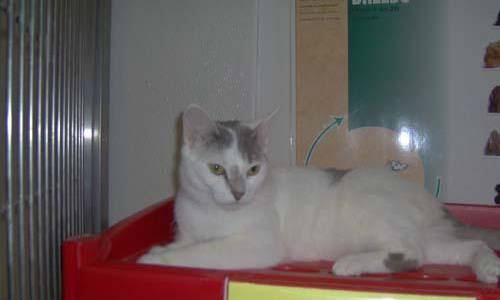

In [63]:
from PIL import Image
import random
isdog = preds[:,1]
isdog = isdog.clip(min=0.05, max=0.95)
idx=int(random.random()*len(preds))
print idx
print preds[idx]
print isdog[idx]
print filenames[idx]
print len(preds)

Image.open(valid+"/" + filenames[idx])


In [ ]:
save_array(results_path + '/test_preds.dat', preds)
save_array(results_path + '/filenames.dat', filenames)